In [ ]:
!pip install pandas transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 9.9 MB/s 
     |████████████████████████████████| 7.6 MB 20.8 MB/s 
     |████████████████████████████████| 182 kB 69.0 MB/s 


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import sys
import csv
import pandas as pd

csv.field_size_limit(sys.maxsize)

fr = open("/content/drive/MyDrive/collectionandqueries/queries.train.tsv", "r")

input_file = csv.reader(fr, delimiter = "\t")

final_query_ids = {}

count = 0
n_count = 0
index = 0

for query_id, query_text in input_file:
    final_query_ids[query_id] = query_text
      
print ('final_query_ids : ' + str(len(final_query_ids)))

final_query_ids : 808731


In [ ]:
import sys
import csv
import pandas as pd

csv.field_size_limit(sys.maxsize)

fr = open("/content/drive/MyDrive/collectionandqueries/20KDocs/qrels_fulldocs_subset_preprocessed_20K.tsv", "r")
qrels_doc_ids = {}
qrels_docs = {}

input_file = csv.reader(fr, delimiter = "\t")

count = 0
max_count = 20000

for DocID, Doc in input_file:
    count = count + 1
    if (count == 1):
      continue
    #print('count of qrels : ' + str(count))
    if DocID in qrels_doc_ids.keys():  
      qrels_doc_ids[DocID] = qrels_doc_ids[DocID] + 1
    else:
      qrels_doc_ids[DocID] = 1 
      qrels_docs[DocID] = Doc  
    if (count > max_count):
      break    
print('len(qrels_doc_ids) : ' + str(len(qrels_doc_ids)))
print('len(qrels_docs) : ' + str(len(qrels_docs)))

len(qrels_doc_ids) : 20000
len(qrels_docs) : 20000


In [ ]:
import sys
import csv
import pandas as pd

csv.field_size_limit(sys.maxsize)

fr = open("/content/drive/MyDrive/collectionandqueries/qrels.train.tsv", "r")

input_file = csv.reader(fr, delimiter = "\t")

query_ids = []
queries = []
document_ids = [] 
labels = []
documents = []

count = 0
max_count = 5000
index = 0

for query_id, qo, document_id, relevance in input_file:
    if document_id in qrels_doc_ids.keys() and query_id in final_query_ids.keys():  
      query_ids.append(query_id)
      queries.append(final_query_ids[query_id])
      document_ids.append(document_id)
      documents.append(qrels_docs[document_id])
      labels.append(int(relevance))
      count = count + 1
      if (count >= max_count):
        break
print('len(qrels_query_ids) : ' + str(len(query_ids)))
print('len(queries) : ' + str(len(queries)))
print('len(document_ids) : ' + str(len(document_ids)))
print('len(documents) : ' + str(len(documents)))
print('len(labels) : ' + str(len(labels)))
print('count : ' + str(count))

len(qrels_query_ids) : 5000
len(queries) : 5000
len(document_ids) : 5000
len(documents) : 5000
len(labels) : 5000
count : 5000


In [ ]:
from sklearn.model_selection import train_test_split
train_queries, val_queries, train_docs, val_docs, train_labels, val_labels = train_test_split(
    queries, 
    documents, 
    labels, 
    test_size=.2
)

In [ ]:
from transformers import BertTokenizerFast

model_name = "google/bert_uncased_L-4_H-512_A-8"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_queries, train_docs, truncation=True, padding='max_length', max_length=128)
val_encodings = tokenizer(val_queries, val_docs, truncation=True, padding='max_length', max_length=128)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

In [ ]:
import torch

class OurDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = OurDataset(train_encodings, train_labels)
val_dataset = OurDataset(val_encodings, val_labels)


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(model_name)

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [ ]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.5 MB/s 
     |████████████████████████████████| 212 kB 18.6 MB/s 
     |████████████████████████████████| 451 kB 53.8 MB/s 
     |████████████████████████████████| 132 kB 56.1 MB/s 
     |████████████████████████████████| 127 kB 63.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import ndcg_score
from sklearn.metrics import classification_report
import numpy as np
import evaluate
import tensorflow as tf


"""
def my_compute_metrics_ndcg(eval_pred):
    predictions, labels = eval_pred
    print ('predictions : ' + str(predictions))
    predictions2 = tf.nn.log_softmax(predictions, axis=-1)
    #print(classification_report(labels, predictions))
    return ndcg_score(predictions2, labels)
"""

def my_compute_metrics_precision(eval_pred):
    predictions, labels = eval_pred
    metric = evaluate.load("precision")
    #print('predictions : ' + str(predictions))
    #print('labels : ' + str(labels))
    #if task != "stsb":
    predictions = np.argmax(predictions, axis=-1)
    #else:
    #predictions = predictions[:]
    print(classification_report(labels, predictions))
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.    
)


trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    #compute_metrics = my_compute_metrics_ndcg
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 1026


Epoch,Training Loss,Validation Loss
1,No log,0.002679
2,0.003900,0.000770


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 64


TypeError: ignored

In [ ]:
pip install trectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for trectools: filename=trectools-0.0.49-py3-none-any.whl size=27140 sha256=a6bd070f16cc24a35aefae315dfbf82fc45ef2cfa83019406cec0d6b88f0c0ae
  Stored in directory: /root/.cache/pip/wheels/6a/cd/17/9a6b28af70445d948c97018b43b9181acd2fdd23e115ee2055
Successfully built trectools


In [ ]:
pred = trainer.predict(val_dataset)
#predictions = 
#print('pred : ' + str(pred))

# making qrel 
qrel = {}
qids, seen, i = [], {}, 0
for q in val_queries:
  if q in seen:
    qids.append(seen[q])
  else:
    seen[q] = i
    qids.append(i)
    i+=1
qrel={
    "query": qids,
    "q0": val_queries,
    "docid": val_docs,
    "rel": val_labels
}
run = {
    "query": qids,
    "q0": val_queries,
    "docid": val_docs,
    "rank": pred[1].tolist(),
    "score": [max(l) for l in pred[0].tolist()],
    "system": ["test" for i in qids]
}
trec_eval = evaluate.load("trec_eval")
results = trec_eval.compute(references=[qrel], predictions=[run])
results

***** Running Prediction *****
  Num examples = 1000
  Batch size = 64


{'runid': 'test',
 'num_ret': 1000,
 'num_rel': 1000,
 'num_rel_ret': 1000,
 'num_q': 977,
 'map': 1.0,
 'gm_map': 1.0,
 'bpref': 0.0,
 'Rprec': 1.0,
 'recip_rank': 1.0,
 'P@5': 0.20470829068577281,
 'P@10': 0.10235414534288641,
 'P@15': 0.0682360968952576,
 'P@20': 0.051177072671443204,
 'P@30': 0.0341180484476288,
 'P@100': 0.01023541453428864,
 'P@200': 0.00511770726714432,
 'P@500': 0.0020470829068577286,
 'P@1000': 0.0010235414534288643,
 'NDCG@5': 1.0,
 'NDCG@10': 1.0,
 'NDCG@15': 1.0,
 'NDCG@20': 1.0,
 'NDCG@30': 1.0,
 'NDCG@100': 1.0,
 'NDCG@200': 1.0,
 'NDCG@500': 1.0,
 'NDCG@1000': 1.0}

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1000

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



{'eval_loss': 0.010652759112417698,
 'eval_precision': 1.0,
 'eval_runtime': 3.1007,
 'eval_samples_per_second': 322.511,
 'eval_steps_per_second': 5.16,
 'epoch': 2.0}

In [ ]:
import pandas
from pandas import read_csv
training_data = read_csv("/content/drive/MyDrive/collectionandqueries/20KDocs/qrels_fulldocs_subset_preprocessed_20K.tsv", delimiter = "\t")
training_data.head()

,document_id,document_text
0,16,approach base theory justice consider crime wr...
1,49,colorâurine variety colors often shades yell...
2,60,inborn error bile acid synthesis produce lifet...
3,81,organ left side body cause pain left rib cage ...
4,389,word convict elegcw elegxo means bring light e...


In [ ]:
import pandas
from pandas import read_csv
all_queries = read_csv("/content/drive/MyDrive/collectionandqueries/20KDocs/qrels_queries.tsv", delimiter = "\t")
all_queries.head()

,query_id,query_text
0,737889,what is decentralization process.
1,570009,what are the four major groups of elements
2,918533,what was introduced to the human diet in what ...
3,1176220,average temperatures barcelona israel
4,291569,how many pairs of chromosomes in a human cell


In [ ]:
import pandas
from pandas import read_csv
all_qrels = read_csv("/content/drive/MyDrive/collectionandqueries/qrels.train.tsv", delimiter = "\t")
all_qrels.head()

,1185869,0,0.1,1
0,1185868,0,16,1
1,597651,0,49,1
2,403613,0,60,1
3,1183785,0,389,1
4,312651,0,616,1


In [ ]:
len(training_data["document_text"])

20000

In [ ]:
from sklearn.model_selection import train_test_split
train_queries, val_queries, train_docs, val_docs, train_labels, val_labels = train_test_split(
    training_data["document_id"].tolist(), 
    training_data["document_text"].tolist(), 
    #training_data["label"].tolist(), 
    test_size=.2
)

ValueError: ignored

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 24.2 MB/s 
     |████████████████████████████████| 7.6 MB 58.9 MB/s 
     |████████████████████████████████| 182 kB 77.0 MB/s 


In [ ]:
import os

pos_neg_ration = 4

# Maximal number of training samples we want to use
max_train_samples = 5e4


### Now we read the MS Marco dataset
data_folder = '/content/drive/MyDrive/collectionandqueries/'
os.makedirs(data_folder, exist_ok=True)


#### Read the corpus files, that contain all the passages. Store them in the corpus dict
corpus = {}
collection_filepath = os.path.join(data_folder, 'collection.tsv')
if not os.path.exists(collection_filepath):
    print('collection.tsv not found')

with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        corpus[pid] = passage
print('len(corpus.keys() : ' + str(len(corpus.keys())))

### Read the train queries, store in queries dict
queries = {}
queries_filepath = os.path.join(data_folder, 'queries.train.tsv')
if not os.path.exists(queries_filepath):
    print('queries.train.tsv not found')

with open(queries_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, query = line.strip().split("\t")
        queries[qid] = query

print('len(queries.keys() : ' + str(len(queries.keys())))

### Now we create our training & dev data
all_query_ids = []
all_queries = []
all_document_ids = [] 
all_labels = []
all_documents = []

"""
train_samples = []
dev_samples = {}

# We use 200 random queries from the train set for evaluation during training
# Each query has at least one relevant and up to 200 irrelevant (negative) passages
num_dev_queries = 200
num_max_dev_negatives = 200

# msmarco-qidpidtriples.rnd-shuf.train-eval.tsv.gz and msmarco-qidpidtriples.rnd-shuf.train.tsv.gz is a randomly
# shuffled version of qidpidtriples.train.full.2.tsv.gz from the MS Marco website
# We extracted in the train-eval split 500 random queries that can be used for evaluation during training
train_eval_filepath = os.path.join(data_folder, 'msmarco-qidpidtriples.rnd-shuf.train-eval.tsv')
if not os.path.exists(train_eval_filepath):
    print('msmarco-qidpidtriples.rnd-shuf.train-eval.tsv not found')

with open(train_eval_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, pos_id, neg_id = line.strip().split()

        if qid not in dev_samples and len(dev_samples) < num_dev_queries:
            dev_samples[qid] = {'query': queries[qid], 'positive': set(), 'negative': set()}

        if qid in dev_samples:
            dev_samples[qid]['positive'].add(corpus[pos_id])
            all_query_ids.append(qid)
            all_queries.append(queries[qid])
            all_document_ids.append(pos_id)
            all_documents.append(corpus([pos_id]))
            all_labels.append(1)
            

            if len(dev_samples[qid]['negative']) < num_max_dev_negatives:
                dev_samples[qid]['negative'].add(corpus[neg_id])
                all_query_ids.append(qid)
                all_queries.append(queries[qid])
                all_document_ids.append(neg_id)
                all_documents.append(corpus([neg_id]))
                all_labels.append(0)
                

print('len(dev_samples.keys()) : ' + str(len(dev_samples.keys())))
"""

# Read our training file
train_filepath = os.path.join(data_folder, 'qidpidtriples-subset.train-200K.tsv')
if not os.path.exists(train_filepath):
    print('qidpidtriples-subset.train-200K.tsv not found')

cnt = 0
with open(train_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, pos_id, neg_id = line.strip().split()

        query = queries[qid]
        if (cnt % (pos_neg_ration+1)) == 0:
            passage = corpus[pos_id]
            label = 1
            all_query_ids.append(qid)
            all_queries.append(query)
            all_document_ids.append(pos_id)
            all_documents.append(passage)
            all_labels.append(label)
        else:
            passage = corpus[neg_id]
            label = 0
            all_query_ids.append(qid)
            all_queries.append(queries[qid])
            all_document_ids.append(neg_id)
            all_documents.append(passage)
            all_labels.append(label)

        #train_samples.append(InputExample(texts=[query, passage], label=label))
        cnt += 1

        if cnt >= max_train_samples:
            break
print('len(all_query_ids) : ' + str(len(all_query_ids)))
print('len(all_queries) : ' + str(len(all_queries)))
print('len(all_document_ids) : ' + str(len(all_document_ids)))
print('len(all_documents) : ' + str(len(all_documents)))
print('len(all_labels) : ' + str(len(all_labels)))

len(corpus.keys() : 8841823
len(queries.keys() : 808731
len(all_query_ids) : 50000
len(all_queries) : 50000
len(all_document_ids) : 50000
len(all_documents) : 50000
len(all_labels) : 50000


In [ ]:
from sklearn.model_selection import train_test_split
train_queries, val_queries, train_docs, val_docs, train_labels, val_labels = train_test_split(
    all_queries, 
    all_documents, 
    all_labels, 
    test_size=.2
)

In [ ]:
from transformers import BertTokenizerFast

model_name = "google/bert_uncased_L-4_H-512_A-8"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_queries, train_docs, truncation=True, padding='max_length', max_length=128)
val_encodings = tokenizer(val_queries, val_docs, truncation=True, padding='max_length', max_length=128)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--google--bert_uncased_L-4_H-512_A-8/snapshots/606e4d55252882ac25ba1f1d1a182075830f5a90/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--bert_uncased_L-4_H-512_A-8/snapshots/606e4d55252882ac25ba1f1d1a182075830f5a90/config.json
Model config BertConfig {
  "_name_or_path": "google/bert_uncased_L-4_H-512_A-8",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_toke

In [ ]:
import torch

class OurDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = OurDataset(train_encodings, train_labels)
val_dataset = OurDataset(val_encodings, val_labels)


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(model_name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--bert_uncased_L-4_H-512_A-8/snapshots/606e4d55252882ac25ba1f1d1a182075830f5a90/config.json
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--bert_uncased_L-4_H-512_A-8/snapshots/606e4d55252882ac25ba1f1d1a182075830f5a90/pytorch_model.bin
Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not

In [ ]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import ndcg_score
from sklearn.metrics import classification_report
import numpy as np
import evaluate
import tensorflow as tf


"""
def my_compute_metrics_ndcg(eval_pred):
    predictions, labels = eval_pred
    print ('predictions : ' + str(predictions))
    predictions2 = tf.nn.log_softmax(predictions, axis=-1)
    #print(classification_report(labels, predictions))
    return ndcg_score(predictions2, labels)
"""

def my_compute_metrics_precision(eval_pred):
    predictions, labels = eval_pred
    metric = evaluate.load("precision")
    #print('predictions : ' + str(predictions))
    #print('labels : ' + str(labels))
    #if task != "stsb":
    predictions = np.argmax(predictions, axis=-1)
    #else:
    #predictions = predictions[:]
    print(classification_report(labels, predictions))
    return metric.compute(predictions=predictions, references=labels)


# You can define your custom compute_metrics function. It takes an `EvalPrediction` object (a namedtuple with a
# predictions and label_ids field) and has to return a dictionary string to float.
def compute_metrics2(pred):
    """
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)   
    """
    print('pred : ' + str(pred))
    # Get the metric function
    trec_eval = evaluate.load("trec_eval")
    qrel = {}
    qids, seen, i = [], {}, 0
    for q in val_queries:
      if q in seen:
        qids.append(seen[q])
      else:
        seen[q] = i
        qids.append(i)
        i+=1
    qrel={
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rel": val_labels
    }
    run = {
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rank": pred[1].tolist(),
      "score": [max(l) for l in pred[0].tolist()],
      "system": ["test" for i in qids]
    }    
    results = trec_eval.compute(references=[qrel], predictions=[run]) 
    return results

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    learning_rate=0.005,
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.    
)


trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics = compute_metrics2
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 40000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5000
  Number of trainable parameters = 1026


Epoch,Training Loss,Validation Loss,Runid,Num Ret,Num Rel,Num Rel Ret,Num Q,Map,Gm Map,Bpref,Rprec,Recip Rank,P@5,P@10,P@15,P@20,P@30,P@100,P@200,P@500,P@1000,Ndcg@5,Ndcg@10,Ndcg@15,Ndcg@20,Ndcg@30,Ndcg@100,Ndcg@200,Ndcg@500,Ndcg@1000
1,0.408400,0.398975,test,10000,2019,2027,9861,0.203833,nan,0.001217,0.201907,0.202921,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
2,0.337000,0.316938,test,10000,2019,2027,9861,0.203630,nan,0.000811,0.201501,0.202718,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-5000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Deleting older checkpoint [results/ch

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8935ed00a0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3000/config.json
Model weights saved in ./results/checkpoint-3000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-3500
Configuration saved in ./results/checkpoint-3500/config.json
Model weights saved in ./results/checkpoint-3500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-3000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-4000
Configuration saved in ./results/checkpoint-4000/config.json
Model weights saved in ./results/checkpoint-4000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-3500] due to args.save_total_limit
Saving model ch

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f88374a5f10>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=5000, training_loss=0.3905830169677734, metrics={'train_runtime': 158.1736, 'train_samples_per_second': 505.774, 'train_steps_per_second': 31.611, 'total_flos': 790993428480000.0, 'train_loss': 0.3905830169677734, 'epoch': 2.0})

In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import ndcg_score
from sklearn.metrics import classification_report
import numpy as np
import evaluate
import tensorflow as tf


"""
def my_compute_metrics_ndcg(eval_pred):
    predictions, labels = eval_pred
    print ('predictions : ' + str(predictions))
    predictions2 = tf.nn.log_softmax(predictions, axis=-1)
    #print(classification_report(labels, predictions))
    return ndcg_score(predictions2, labels)
"""

def my_compute_metrics_precision(eval_pred):
    predictions, labels = eval_pred
    metric = evaluate.load("precision")
    #print('predictions : ' + str(predictions))
    #print('labels : ' + str(labels))
    #if task != "stsb":
    predictions = np.argmax(predictions, axis=-1)
    #else:
    #predictions = predictions[:]
    print(classification_report(labels, predictions))
    return metric.compute(predictions=predictions, references=labels)


# You can define your custom compute_metrics function. It takes an `EvalPrediction` object (a namedtuple with a
# predictions and label_ids field) and has to return a dictionary string to float.
def compute_metrics2(pred):
    """
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)   
    """
    print('pred : ' + str(pred))
    # Get the metric function
    trec_eval = evaluate.load("trec_eval")
    qrel = {}
    qids, seen, i = [], {}, 0
    for q in val_queries:
      if q in seen:
        qids.append(seen[q])
      else:
        seen[q] = i
        qids.append(i)
        i+=1
    qrel={
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rel": val_labels
    }
    run = {
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rank": pred[1].tolist(),
      "score": [max(l) for l in pred[0].tolist()],
      "system": ["test" for i in qids]
    }    
    results = trec_eval.compute(references=[qrel], predictions=[run]) 
    return results

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    learning_rate=0.5,
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.    
)


trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics = compute_metrics2
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 40000
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 50000
  Number of trainable parameters = 1026


Epoch,Training Loss,Validation Loss,Runid,Num Ret,Num Rel,Num Rel Ret,Num Q,Map,Gm Map,Bpref,Rprec,Recip Rank,P@5,P@10,P@15,P@20,P@30,P@100,P@200,P@500,P@1000,Ndcg@5,Ndcg@10,Ndcg@15,Ndcg@20,Ndcg@30,Ndcg@100,Ndcg@200,Ndcg@500,Ndcg@1000
1,12.781900,8.927734,test,10000,2019,2027,9861,0.204239,nan,0.002028,0.202718,0.203326,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
2,10.490900,9.888544,test,10000,2019,2027,9861,0.203580,nan,0.000710,0.201399,0.202667,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
3,12.961900,16.784935,test,10000,2019,2027,9861,0.204442,nan,0.002434,0.203123,0.203529,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
4,11.634700,26.208387,test,10000,2019,2027,9861,0.204797,nan,0.003144,0.203833,0.203884,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
5,9.840400,9.297599,test,10000,2019,2027,9861,0.204340,nan,0.002231,0.202921,0.203428,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
6,8.801800,4.364242,test,10000,2019,2027,9861,0.203833,nan,0.001217,0.201907,0.202921,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
7,8.928300,4.940401,test,10000,2019,2027,9861,0.203783,nan,0.001116,0.201805,0.202870,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
8,7.190100,6.363775,test,10000,2019,2027,9861,0.203428,nan,0.000406,0.201095,0.202515,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
9,7.104800,3.605003,test,10000,2019,2027,9861,0.203630,nan,0.000811,0.201501,0.202718,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035
10,7.423800,4.504321,test,10000,2019,2027,9861,0.203985,nan,0.001521,0.202211,0.203073,0.041111,0.020556,0.013704,0.010278,0.006852,0.002056,0.001028,0.000411,0.000206,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035,0.204035


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-5000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Deleting older checkpoint [results/ch

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8833ea3370>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3000/config.json
Model weights saved in ./results/checkpoint-3000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-3500
Configuration saved in ./results/checkpoint-3500/config.json
Model weights saved in ./results/checkpoint-3500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-3000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-4000
Configuration saved in ./results/checkpoint-4000/config.json
Model weights saved in ./results/checkpoint-4000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-3500] due to args.save_total_limit
Saving model ch

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8935d95b20>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-5500
Configuration saved in ./results/checkpoint-5500/config.json
Model weights saved in ./results/checkpoint-5500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-5000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-6000
Configuration saved in ./results/checkpoint-6000/config.json
Model weights saved in ./results/checkpoint-6000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-5500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-6500
Configuration saved in ./results/checkpoint-6500/config.json
Model weights saved in ./results/checkpoint-6500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-6000] due to args.save_total_limit
Saving model ch

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8935a9a820>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-8000
Configuration saved in ./results/checkpoint-8000/config.json
Model weights saved in ./results/checkpoint-8000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-7500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-8500
Configuration saved in ./results/checkpoint-8500/config.json
Model weights saved in ./results/checkpoint-8500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-8000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-9000
Configuration saved in ./results/checkpoint-9000/config.json
Model weights saved in ./results/checkpoint-9000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-8500] due to args.save_total_limit
Saving model ch

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8a72d17df0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-10500
Configuration saved in ./results/checkpoint-10500/config.json
Model weights saved in ./results/checkpoint-10500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-10000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-11000
Configuration saved in ./results/checkpoint-11000/config.json
Model weights saved in ./results/checkpoint-11000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-10500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-11500
Configuration saved in ./results/checkpoint-11500/config.json
Model weights saved in ./results/checkpoint-11500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-11000] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f893600a040>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-13000
Configuration saved in ./results/checkpoint-13000/config.json
Model weights saved in ./results/checkpoint-13000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-12500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-13500
Configuration saved in ./results/checkpoint-13500/config.json
Model weights saved in ./results/checkpoint-13500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-13000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-14000
Configuration saved in ./results/checkpoint-14000/config.json
Model weights saved in ./results/checkpoint-14000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-13500] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8a72d17df0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-15500
Configuration saved in ./results/checkpoint-15500/config.json
Model weights saved in ./results/checkpoint-15500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-15000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-16000
Configuration saved in ./results/checkpoint-16000/config.json
Model weights saved in ./results/checkpoint-16000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-15500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-16500
Configuration saved in ./results/checkpoint-16500/config.json
Model weights saved in ./results/checkpoint-16500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-16000] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f893ddf4df0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-18000
Configuration saved in ./results/checkpoint-18000/config.json
Model weights saved in ./results/checkpoint-18000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-17500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-18500
Configuration saved in ./results/checkpoint-18500/config.json
Model weights saved in ./results/checkpoint-18500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-18000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-19000
Configuration saved in ./results/checkpoint-19000/config.json
Model weights saved in ./results/checkpoint-19000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-18500] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8832286160>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-20500
Configuration saved in ./results/checkpoint-20500/config.json
Model weights saved in ./results/checkpoint-20500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-20000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-21000
Configuration saved in ./results/checkpoint-21000/config.json
Model weights saved in ./results/checkpoint-21000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-20500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-21500
Configuration saved in ./results/checkpoint-21500/config.json
Model weights saved in ./results/checkpoint-21500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-21000] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f893ddf4df0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-23000
Configuration saved in ./results/checkpoint-23000/config.json
Model weights saved in ./results/checkpoint-23000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-22500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-23500
Configuration saved in ./results/checkpoint-23500/config.json
Model weights saved in ./results/checkpoint-23500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-23000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-24000
Configuration saved in ./results/checkpoint-24000/config.json
Model weights saved in ./results/checkpoint-24000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-23500] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8934e5eb20>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-25500
Configuration saved in ./results/checkpoint-25500/config.json
Model weights saved in ./results/checkpoint-25500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-25000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-26000
Configuration saved in ./results/checkpoint-26000/config.json
Model weights saved in ./results/checkpoint-26000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-25500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-26500
Configuration saved in ./results/checkpoint-26500/config.json
Model weights saved in ./results/checkpoint-26500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-26000] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f893a20e640>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-28000
Configuration saved in ./results/checkpoint-28000/config.json
Model weights saved in ./results/checkpoint-28000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-27500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-28500
Configuration saved in ./results/checkpoint-28500/config.json
Model weights saved in ./results/checkpoint-28500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-28000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-29000
Configuration saved in ./results/checkpoint-29000/config.json
Model weights saved in ./results/checkpoint-29000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-28500] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8934e5eb20>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-30500
Configuration saved in ./results/checkpoint-30500/config.json
Model weights saved in ./results/checkpoint-30500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-30000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-31000
Configuration saved in ./results/checkpoint-31000/config.json
Model weights saved in ./results/checkpoint-31000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-30500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-31500
Configuration saved in ./results/checkpoint-31500/config.json
Model weights saved in ./results/checkpoint-31500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-31000] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8936e5a040>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-33000
Configuration saved in ./results/checkpoint-33000/config.json
Model weights saved in ./results/checkpoint-33000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-32500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-33500
Configuration saved in ./results/checkpoint-33500/config.json
Model weights saved in ./results/checkpoint-33500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-33000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-34000
Configuration saved in ./results/checkpoint-34000/config.json
Model weights saved in ./results/checkpoint-34000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-33500] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8934e5eb20>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-35500
Configuration saved in ./results/checkpoint-35500/config.json
Model weights saved in ./results/checkpoint-35500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-35000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-36000
Configuration saved in ./results/checkpoint-36000/config.json
Model weights saved in ./results/checkpoint-36000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-35500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-36500
Configuration saved in ./results/checkpoint-36500/config.json
Model weights saved in ./results/checkpoint-36500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-36000] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8936e5a040>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-38000
Configuration saved in ./results/checkpoint-38000/config.json
Model weights saved in ./results/checkpoint-38000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-37500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-38500
Configuration saved in ./results/checkpoint-38500/config.json
Model weights saved in ./results/checkpoint-38500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-38000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-39000
Configuration saved in ./results/checkpoint-39000/config.json
Model weights saved in ./results/checkpoint-39000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-38500] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8846975f40>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-40500
Configuration saved in ./results/checkpoint-40500/config.json
Model weights saved in ./results/checkpoint-40500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-40000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-41000
Configuration saved in ./results/checkpoint-41000/config.json
Model weights saved in ./results/checkpoint-41000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-40500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-41500
Configuration saved in ./results/checkpoint-41500/config.json
Model weights saved in ./results/checkpoint-41500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-41000] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8935ca2670>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-43000
Configuration saved in ./results/checkpoint-43000/config.json
Model weights saved in ./results/checkpoint-43000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-42500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-43500
Configuration saved in ./results/checkpoint-43500/config.json
Model weights saved in ./results/checkpoint-43500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-43000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-44000
Configuration saved in ./results/checkpoint-44000/config.json
Model weights saved in ./results/checkpoint-44000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-43500] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f89349ae0a0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-45500
Configuration saved in ./results/checkpoint-45500/config.json
Model weights saved in ./results/checkpoint-45500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-45000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-46000
Configuration saved in ./results/checkpoint-46000/config.json
Model weights saved in ./results/checkpoint-46000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-45500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-46500
Configuration saved in ./results/checkpoint-46500/config.json
Model weights saved in ./results/checkpoint-46500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-46000] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8936e5a040>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-48000
Configuration saved in ./results/checkpoint-48000/config.json
Model weights saved in ./results/checkpoint-48000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-47500] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-48500
Configuration saved in ./results/checkpoint-48500/config.json
Model weights saved in ./results/checkpoint-48500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-48000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-49000
Configuration saved in ./results/checkpoint-49000/config.json
Model weights saved in ./results/checkpoint-49000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-48500] due to args.save_total_limit
Sav

pred : <transformers.trainer_utils.EvalPrediction object at 0x7f8832035f70>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=50000, training_loss=6.857176039428711, metrics={'train_runtime': 1498.803, 'train_samples_per_second': 533.759, 'train_steps_per_second': 33.36, 'total_flos': 7909934284800000.0, 'train_loss': 6.857176039428711, 'epoch': 20.0})

In [ ]:
pip install trectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pred = trainer.predict(val_dataset)
#predictions = 
#print('pred : ' + str(pred))

# making qrel 
qrel = {}
qids, seen, i = [], {}, 0
for q in val_queries:
  if q in seen:
    qids.append(seen[q])
  else:
    seen[q] = i
    qids.append(i)
    i+=1
qrel={
    "query": qids,
    "q0": val_queries,
    "docid": val_docs,
    "rel": val_labels
}
run = {
    "query": qids,
    "q0": val_queries,
    "docid": val_docs,
    "rank": pred[1].tolist(),
    "score": [max(l) for l in pred[0].tolist()],
    "system": ["test" for i in qids]
}
trec_eval = evaluate.load("trec_eval")
results = trec_eval.compute(references=[qrel], predictions=[run])
results

***** Running Prediction *****
  Num examples = 10000
  Batch size = 64


{'runid': 'test',
 'num_ret': 10000,
 'num_rel': 2019,
 'num_rel_ret': 2027,
 'num_q': 9861,
 'map': 0.20373187303518914,
 'gm_map': nan,
 'bpref': 0.0010140959334753068,
 'Rprec': 0.2017036811682385,
 'recip_rank': 0.20281918669506135,
 'P@5': 0.04111144914308894,
 'P@10': 0.02055572457154447,
 'P@15': 0.013703816381029644,
 'P@20': 0.010277862285772234,
 'P@30': 0.006851908190514822,
 'P@100': 0.002055572457154447,
 'P@200': 0.0010277862285772235,
 'P@500': 0.0004111144914308894,
 'P@1000': 0.0002055572457154447,
 'NDCG@5': 0.20403485096013158,
 'NDCG@10': 0.20403485096013158,
 'NDCG@15': 0.20403485096013158,
 'NDCG@20': 0.20403485096013158,
 'NDCG@30': 0.20403485096013158,
 'NDCG@100': 0.20403485096013158,
 'NDCG@200': 0.20403485096013158,
 'NDCG@500': 0.20403485096013158,
 'NDCG@1000': 0.20403485096013158}

In [ ]:
####Topic based queries

In [ ]:
import os

pos_neg_ration = 4

# Maximal number of training samples we want to use
max_train_samples = 5e4


### Now we read the MS Marco dataset
data_folder = '/content/drive/MyDrive/collectionandqueries/'
os.makedirs(data_folder, exist_ok=True)


#### Read the corpus files, that contain all the passages. Store them in the corpus dict
corpus = {}
collection_filepath = os.path.join(data_folder, 'collection.tsv')
if not os.path.exists(collection_filepath):
    print('collection.tsv not found')

with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        corpus[pid] = passage
print('len(corpus.keys() : ' + str(len(corpus.keys())))

### Read the train queries, store in queries dict
queries = {}
queries_filepath = os.path.join(data_folder, 'queries.train.tsv')
if not os.path.exists(queries_filepath):
    print('queries.train.tsv not found')

with open(queries_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, query = line.strip().split("\t")
        queries[qid] = query

print('len(queries.keys() : ' + str(len(queries.keys())))

### Now we create our training & dev data
original_query_ids = []
original_queries = []
original_document_ids = [] 
original_labels = []
original_documents = []

"""
train_samples = []
dev_samples = {}

# We use 200 random queries from the train set for evaluation during training
# Each query has at least one relevant and up to 200 irrelevant (negative) passages
num_dev_queries = 200
num_max_dev_negatives = 200

# msmarco-qidpidtriples.rnd-shuf.train-eval.tsv.gz and msmarco-qidpidtriples.rnd-shuf.train.tsv.gz is a randomly
# shuffled version of qidpidtriples.train.full.2.tsv.gz from the MS Marco website
# We extracted in the train-eval split 500 random queries that can be used for evaluation during training
train_eval_filepath = os.path.join(data_folder, 'msmarco-qidpidtriples.rnd-shuf.train-eval.tsv')
if not os.path.exists(train_eval_filepath):
    print('msmarco-qidpidtriples.rnd-shuf.train-eval.tsv not found')

with open(train_eval_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, pos_id, neg_id = line.strip().split()

        if qid not in dev_samples and len(dev_samples) < num_dev_queries:
            dev_samples[qid] = {'query': queries[qid], 'positive': set(), 'negative': set()}

        if qid in dev_samples:
            dev_samples[qid]['positive'].add(corpus[pos_id])
            all_query_ids.append(qid)
            all_queries.append(queries[qid])
            all_document_ids.append(pos_id)
            all_documents.append(corpus([pos_id]))
            all_labels.append(1)
            

            if len(dev_samples[qid]['negative']) < num_max_dev_negatives:
                dev_samples[qid]['negative'].add(corpus[neg_id])
                all_query_ids.append(qid)
                all_queries.append(queries[qid])
                all_document_ids.append(neg_id)
                all_documents.append(corpus([neg_id]))
                all_labels.append(0)
                

print('len(dev_samples.keys()) : ' + str(len(dev_samples.keys())))
"""

# Read our training file
train_filepath = os.path.join(data_folder, 'qidpidtriples-subset.train-200K.tsv')
if not os.path.exists(train_filepath):
    print('qidpidtriples-subset.train-200K.tsv not found')

cnt = 0
with open(train_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, pos_id, neg_id = line.strip().split()

        query = queries[qid]
        if (cnt % (pos_neg_ration+1)) == 0:
            passage = corpus[pos_id]
            label = 1
            original_query_ids.append(qid)
            original_queries.append(query)
            original_document_ids.append(pos_id)
            original_documents.append(passage)
            original_labels.append(label)
        else:
            passage = corpus[neg_id]
            label = 0
            original_query_ids.append(qid)
            original_queries.append(queries[qid])
            original_document_ids.append(neg_id)
            original_documents.append(passage)
            original_labels.append(label)

        #train_samples.append(InputExample(texts=[query, passage], label=label))
        cnt += 1

        if cnt >= max_train_samples:
            break
print('len(original_query_ids) : ' + str(len(original_query_ids)))
print('len(original_queries) : ' + str(len(original_queries)))
print('len(original_document_ids) : ' + str(len(original_document_ids)))
print('len(original_documents) : ' + str(len(original_documents)))
print('len(original_labels) : ' + str(len(original_labels)))

len(corpus.keys() : 8841823
len(queries.keys() : 808731
len(original_query_ids) : 50000
len(original_queries) : 50000
len(original_document_ids) : 50000
len(original_documents) : 50000
len(original_labels) : 50000


In [ ]:
pip install rank_bm25

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
from rank_bm25 import BM25Okapi

tokenized_corpus = [doc.split(" ") for doc in original_documents]
bm25 = BM25Okapi(tokenized_corpus)
with open("/content/drive/MyDrive/collectionandqueries/BM25", 'wb') as bm25File:
  pickle.dump(bm25, bm25File)

In [ ]:
#bm25 baseline

In [ ]:
pip install rank_bm25

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle

with open("/content/drive/MyDrive/collectionandqueries/BM25", 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    bm25 = pickle.load(f)

In [ ]:
import os

pos_neg_ration = 4

# Maximal number of training samples we want to use
#max_train_samples = 5e4
max_train_samples = 5e3

### Now we read the MS Marco dataset
data_folder = '/content/drive/MyDrive/collectionandqueries/'
os.makedirs(data_folder, exist_ok=True)


#### Read the corpus files, that contain all the passages. Store them in the corpus dict
corpus = {}
collection_filepath = os.path.join(data_folder, 'collection.tsv')
if not os.path.exists(collection_filepath):
    print('collection.tsv not found')

with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        corpus[pid] = passage
print('len(corpus.keys() : ' + str(len(corpus.keys())))

### Read the train queries, store in queries dict
queries = {}
queries_filepath = os.path.join(data_folder, 'queries.train.tsv')
if not os.path.exists(queries_filepath):
    print('queries.train.tsv not found')

with open(queries_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, query = line.strip().split("\t")
        queries[qid] = query

print('len(queries.keys() : ' + str(len(queries.keys())))

### Now we create our training & dev data
all_query_ids = []
all_queries = []
all_document_ids = [] 
all_labels = []
all_documents = []

"""
train_samples = []
dev_samples = {}

# We use 200 random queries from the train set for evaluation during training
# Each query has at least one relevant and up to 200 irrelevant (negative) passages
num_dev_queries = 200
num_max_dev_negatives = 200

# msmarco-qidpidtriples.rnd-shuf.train-eval.tsv.gz and msmarco-qidpidtriples.rnd-shuf.train.tsv.gz is a randomly
# shuffled version of qidpidtriples.train.full.2.tsv.gz from the MS Marco website
# We extracted in the train-eval split 500 random queries that can be used for evaluation during training
train_eval_filepath = os.path.join(data_folder, 'msmarco-qidpidtriples.rnd-shuf.train-eval.tsv')
if not os.path.exists(train_eval_filepath):
    print('msmarco-qidpidtriples.rnd-shuf.train-eval.tsv not found')

with open(train_eval_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, pos_id, neg_id = line.strip().split()

        if qid not in dev_samples and len(dev_samples) < num_dev_queries:
            dev_samples[qid] = {'query': queries[qid], 'positive': set(), 'negative': set()}

        if qid in dev_samples:
            dev_samples[qid]['positive'].add(corpus[pos_id])
            all_query_ids.append(qid)
            all_queries.append(queries[qid])
            all_document_ids.append(pos_id)
            all_documents.append(corpus([pos_id]))
            all_labels.append(1)
            

            if len(dev_samples[qid]['negative']) < num_max_dev_negatives:
                dev_samples[qid]['negative'].add(corpus[neg_id])
                all_query_ids.append(qid)
                all_queries.append(queries[qid])
                all_document_ids.append(neg_id)
                all_documents.append(corpus([neg_id]))
                all_labels.append(0)
                

print('len(dev_samples.keys()) : ' + str(len(dev_samples.keys())))
"""

# Read our training file
train_filepath = os.path.join(data_folder, 'qidpidtriples-subset.train-200K.tsv')
if not os.path.exists(train_filepath):
    print('qidpidtriples-subset.train-200K.tsv not found')

cnt = 0
with open(train_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, pos_id, neg_id = line.strip().split()
        print('cnt : ' + str(cnt))
        query = queries[qid]
        if (cnt % (pos_neg_ration+1)) == 0:
            #print('positive')
            passage = corpus[pos_id]
            label = 1
            all_query_ids.append(qid)
            all_queries.append(query)
            all_document_ids.append(pos_id)
            all_documents.append(passage)
            all_labels.append(label)
            bm25_passages = bm25.get_top_n(query, original_documents, n=3)
            for bm25_passage in bm25_passages:
              all_query_ids.append(qid)
              all_queries.append(query)
              all_document_ids.append(pos_id)
              all_documents.append(bm25_passage)
              all_labels.append(label)
        else:
            #print('negative')
            passage = corpus[neg_id]
            label = 0
            all_query_ids.append(qid)
            all_queries.append(queries[qid])
            all_document_ids.append(neg_id)
            all_documents.append(passage)
            all_labels.append(label)

        #train_samples.append(InputExample(texts=[query, passage], label=label))
        cnt += 1

        if cnt >= max_train_samples:
            break
print('len(all_query_ids) : ' + str(len(all_query_ids)))
print('len(all_queries) : ' + str(len(all_queries)))
print('len(all_document_ids) : ' + str(len(all_document_ids)))
print('len(all_documents) : ' + str(len(all_documents)))
print('len(all_labels) : ' + str(len(all_labels)))

Streaming output truncated to the last 5000 lines.
cnt : 5
cnt : 6
cnt : 7
cnt : 8
cnt : 9
cnt : 10
cnt : 11
cnt : 12
cnt : 13
cnt : 14
cnt : 15
cnt : 16
cnt : 17
cnt : 18
cnt : 19
cnt : 20
cnt : 21
cnt : 22
cnt : 23
cnt : 24
cnt : 25
cnt : 26
cnt : 27
cnt : 28
cnt : 29
cnt : 30
cnt : 31
cnt : 32
cnt : 33
cnt : 34
cnt : 35
cnt : 36
cnt : 37
cnt : 38
cnt : 39
cnt : 40
cnt : 41
cnt : 42
cnt : 43
cnt : 44
cnt : 45
cnt : 46
cnt : 47
cnt : 48
cnt : 49
cnt : 50
cnt : 51
cnt : 52
cnt : 53
cnt : 54
cnt : 55
cnt : 56
cnt : 57
cnt : 58
cnt : 59
cnt : 60
cnt : 61
cnt : 62
cnt : 63
cnt : 64
cnt : 65
cnt : 66
cnt : 67
cnt : 68
cnt : 69
cnt : 70
cnt : 71
cnt : 72
cnt : 73
cnt : 74
cnt : 75
cnt : 76
cnt : 77
cnt : 78
cnt : 79
cnt : 80
cnt : 81
cnt : 82
cnt : 83
cnt : 84
cnt : 85
cnt : 86
cnt : 87
cnt : 88
cnt : 89
cnt : 90
cnt : 91
cnt : 92
cnt : 93
cnt : 94
cnt : 95
cnt : 96
cnt : 97
cnt : 98
cnt : 99
cnt : 100
cnt : 101
cnt : 102
cnt : 103
cnt : 104
cnt : 105
cnt : 106
cnt : 107
cnt : 108
cnt : 109

In [ ]:
import csv
import sys

csv.field_size_limit(sys.maxsize)


fw1 = open("/content/drive/MyDrive/collectionandqueries/all_query_ids.tsv", "w")
fw2 = open("/content/drive/MyDrive/collectionandqueries/all_queries.tsv", "w")
fw3 = open("/content/drive/MyDrive/collectionandqueries/all_document_ids.tsv", "w")
fw4 = open("/content/drive/MyDrive/collectionandqueries/all_documents.tsv", "w")
fw5 = open("/content/drive/MyDrive/collectionandqueries/all_labels.tsv", "w")

output_file1 = csv.writer(fw1, delimiter = "\t")
output_file2 = csv.writer(fw2, delimiter = "\t")
output_file3 = csv.writer(fw3, delimiter = "\t")
output_file4 = csv.writer(fw4, delimiter = "\t")
output_file5 = csv.writer(fw5, delimiter = "\t")

index = 0

length = len(all_query_ids)
print('length : ' + str(length))

for index in range(0, length): 
    try:
      output_file1.writerow([all_query_ids[index]])
      output_file2.writerow([all_queries[index]])
      output_file3.writerow([all_document_ids[index]])
      output_file4.writerow([all_documents[index]])
      output_file5.writerow([all_labels[index]])
      index = index+1
    except Exception as e:
      print(str(e))
print('index : ' + str(index))      

length : 8000
index : 8000


In [ ]:
import csv
import sys

csv.field_size_limit(sys.maxsize)


fr1 = open("/content/drive/MyDrive/collectionandqueries/all_query_ids.tsv", "r")
fr2 = open("/content/drive/MyDrive/collectionandqueries/all_queries.tsv", "r")
fr3 = open("/content/drive/MyDrive/collectionandqueries/all_document_ids.tsv", "r")
fr4 = open("/content/drive/MyDrive/collectionandqueries/all_documents.tsv", "r")
fr5 = open("/content/drive/MyDrive/collectionandqueries/all_labels.tsv", "r")

input_file1 = csv.reader(fr1, delimiter = "\t")
input_file2 = csv.reader(fr2, delimiter = "\t")
input_file3 = csv.reader(fr3, delimiter = "\t")
input_file4 = csv.reader(fr4, delimiter = "\t")
input_file5 = csv.reader(fr5, delimiter = "\t")

count = 0

for w in input_file1: 
    count = count+1

print('count1 : ' + str(count))

count = 0

for w in input_file2: 
    count = count+1

print('count2 : ' + str(count))

count = 0

for w in input_file3: 
    count = count+1

print('count3 : ' + str(count))

count = 0

for w in input_file4: 
    count = count+1

print('count4 : ' + str(count))

count = 0

for w in input_file5: 
    count = count+1

print('count5 : ' + str(count))

count1 : 8000
count2 : 8000
count3 : 8000
count4 : 8000
count5 : 8000


In [ ]:
"""
import os

pos_neg_ration = 4

# Maximal number of training samples we want to use
#max_train_samples = 5e4
max_train_samples = 25e3

### Now we read the MS Marco dataset
data_folder = '/content/drive/MyDrive/collectionandqueries/'
os.makedirs(data_folder, exist_ok=True)


#### Read the corpus files, that contain all the passages. Store them in the corpus dict
corpus = {}
collection_filepath = os.path.join(data_folder, 'collection.tsv')
if not os.path.exists(collection_filepath):
    print('collection.tsv not found')

with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        corpus[pid] = passage
print('len(corpus.keys() : ' + str(len(corpus.keys())))

### Read the train queries, store in queries dict
queries = {}
queries_filepath = os.path.join(data_folder, 'queries.train.tsv')
if not os.path.exists(queries_filepath):
    print('queries.train.tsv not found')

with open(queries_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, query = line.strip().split("\t")
        queries[qid] = query

print('len(queries.keys() : ' + str(len(queries.keys())))

### Now we create our training & dev data
all_query_ids = []
all_queries = []
all_document_ids = [] 
all_labels = []
all_documents = []

"""
"""
train_samples = []
dev_samples = {}

# We use 200 random queries from the train set for evaluation during training
# Each query has at least one relevant and up to 200 irrelevant (negative) passages
num_dev_queries = 200
num_max_dev_negatives = 200

# msmarco-qidpidtriples.rnd-shuf.train-eval.tsv.gz and msmarco-qidpidtriples.rnd-shuf.train.tsv.gz is a randomly
# shuffled version of qidpidtriples.train.full.2.tsv.gz from the MS Marco website
# We extracted in the train-eval split 500 random queries that can be used for evaluation during training
train_eval_filepath = os.path.join(data_folder, 'msmarco-qidpidtriples.rnd-shuf.train-eval.tsv')
if not os.path.exists(train_eval_filepath):
    print('msmarco-qidpidtriples.rnd-shuf.train-eval.tsv not found')

with open(train_eval_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, pos_id, neg_id = line.strip().split()

        if qid not in dev_samples and len(dev_samples) < num_dev_queries:
            dev_samples[qid] = {'query': queries[qid], 'positive': set(), 'negative': set()}

        if qid in dev_samples:
            dev_samples[qid]['positive'].add(corpus[pos_id])
            all_query_ids.append(qid)
            all_queries.append(queries[qid])
            all_document_ids.append(pos_id)
            all_documents.append(corpus([pos_id]))
            all_labels.append(1)
            

            if len(dev_samples[qid]['negative']) < num_max_dev_negatives:
                dev_samples[qid]['negative'].add(corpus[neg_id])
                all_query_ids.append(qid)
                all_queries.append(queries[qid])
                all_document_ids.append(neg_id)
                all_documents.append(corpus([neg_id]))
                all_labels.append(0)
                

print('len(dev_samples.keys()) : ' + str(len(dev_samples.keys())))
"""
"""

# Read our training file
train_filepath = os.path.join(data_folder, 'qidpidtriples-subset.train-200K.tsv')
if not os.path.exists(train_filepath):
    print('qidpidtriples-subset.train-200K.tsv not found')

cnt = 0
with open(train_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, pos_id, neg_id = line.strip().split()
        #print('cnt : ' + str(cnt))
        query = queries[qid]
        if (cnt % (pos_neg_ration+1)) == 0:
            #print('positive')
            passage = corpus[pos_id]
            label = 1
            all_query_ids.append(qid)
            all_queries.append(query)
            all_document_ids.append(pos_id)
            all_documents.append(passage)
            all_labels.append(label)
            bm25_passages = bm25.get_top_n(query, original_documents, n=3)
            for bm25_passage in bm25_passages:
              all_query_ids.append(qid)
              all_queries.append(query)
              all_document_ids.append(pos_id)
              all_documents.append(bm25_passage)
              all_labels.append(label)
        else:
            #print('negative')
            passage = corpus[neg_id]
            label = 0
            all_query_ids.append(qid)
            all_queries.append(queries[qid])
            all_document_ids.append(neg_id)
            all_documents.append(passage)
            all_labels.append(label)

        #train_samples.append(InputExample(texts=[query, passage], label=label))
        cnt += 1

        if cnt >= max_train_samples:
            break
print('len(all_query_ids) : ' + str(len(all_query_ids)))
print('len(all_queries) : ' + str(len(all_queries)))
print('len(all_document_ids) : ' + str(len(all_document_ids)))
print('len(all_documents) : ' + str(len(all_documents)))
print('len(all_labels) : ' + str(len(all_labels)))

In [ ]:
from sklearn.model_selection import train_test_split
train_queries, val_queries, train_docs, val_docs, train_labels, val_labels = train_test_split(
    all_queries, 
    all_documents, 
    all_labels, 
    test_size=.2
)

In [ ]:
!pip install pandas transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
from transformers import BertTokenizerFast

model_name = "google/bert_uncased_L-4_H-512_A-8"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_queries, train_docs, truncation=True, padding='max_length', max_length=128)
val_encodings = tokenizer(val_queries, val_docs, truncation=True, padding='max_length', max_length=128)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

In [ ]:
import torch

class OurDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = OurDataset(train_encodings, train_labels)
val_dataset = OurDataset(val_encodings, val_labels)


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(model_name)

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [ ]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 8.2 MB/s 
     |████████████████████████████████| 132 kB 30.3 MB/s 
     |████████████████████████████████| 451 kB 74.8 MB/s 
     |████████████████████████████████| 212 kB 75.7 MB/s 
     |████████████████████████████████| 127 kB 81.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
pip install trectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for trectools: filename=trectools-0.0.49-py3-none-any.whl size=27140 sha256=cac2897548db07af7159a2f2daad9c670966cfb5a932b1dd3a19724d6802837f
  Stored in directory: /root/.cache/pip/wheels/6a/cd/17/9a6b28af70445d948c97018b43b9181acd2fdd23e115ee2055
Successfully built trectools


In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import ndcg_score
from sklearn.metrics import classification_report
import numpy as np
import evaluate
import tensorflow as tf


"""
def my_compute_metrics_ndcg(eval_pred):
    predictions, labels = eval_pred
    print ('predictions : ' + str(predictions))
    predictions2 = tf.nn.log_softmax(predictions, axis=-1)
    #print(classification_report(labels, predictions))
    return ndcg_score(predictions2, labels)
"""

def my_compute_metrics_precision(eval_pred):
    predictions, labels = eval_pred
    metric = evaluate.load("precision")
    #print('predictions : ' + str(predictions))
    #print('labels : ' + str(labels))
    #if task != "stsb":
    predictions = np.argmax(predictions, axis=-1)
    #else:
    #predictions = predictions[:]
    print(classification_report(labels, predictions))
    return metric.compute(predictions=predictions, references=labels)


# You can define your custom compute_metrics function. It takes an `EvalPrediction` object (a namedtuple with a
# predictions and label_ids field) and has to return a dictionary string to float.
def compute_metrics2(pred):
    """
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)   
    """
    print('pred : ' + str(pred))
    # Get the metric function
    trec_eval = evaluate.load("trec_eval")
    qrel = {}
    qids, seen, i = [], {}, 0
    for q in val_queries:
      if q in seen:
        qids.append(seen[q])
      else:
        seen[q] = i
        qids.append(i)
        i+=1
    qrel={
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rel": val_labels
    }
    run = {
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rank": pred[1].tolist(),
      "score": [max(l) for l in pred[0].tolist()],
      "system": ["test" for i in qids]
    }    
    results = trec_eval.compute(references=[qrel], predictions=[run]) 
    return results

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    learning_rate=0.00005,
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.    
)


trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics = compute_metrics2
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6400
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8000
  Number of trainable parameters = 1026


Epoch,Training Loss,Validation Loss,Runid,Num Ret,Num Rel,Num Rel Ret,Num Q,Map,Gm Map,Bpref,Rprec,Recip Rank,P@5,P@10,P@15,P@20,P@30,P@100,P@200,P@500,P@1000,Ndcg@5,Ndcg@10,Ndcg@15,Ndcg@20,Ndcg@30,Ndcg@100,Ndcg@200,Ndcg@500,Ndcg@1000
1,No log,0.324710,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
2,0.363700,0.325363,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
3,0.366500,0.322516,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
4,0.380400,0.321213,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
5,0.368500,0.324815,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
6,0.368500,0.320435,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
7,0.375400,0.321186,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
8,0.380700,0.318820,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
9,0.381900,0.320785,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
10,0.371300,0.320345,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941


***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b100d3370>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b06366f10>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aedf060a0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecf86e50>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecc71130>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b0dc44f70>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5bf9a30ee0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3000/config.json
Model weights saved in ./results/checkpoint-3000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecc71910>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-3500
Configuration saved in ./results/checkpoint-3500/config.json
Model weights saved in ./results/checkpoint-3500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-3000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b102a5640>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-4000
Configuration saved in ./results/checkpoint-4000/config.json
Model weights saved in ./results/checkpoint-4000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-3500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecc94ee0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b102a5640>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-4500
Configuration saved in ./results/checkpoint-4500/config.json
Model weights saved in ./results/checkpoint-4500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-4000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b0dc44f10>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-5000
Configuration saved in ./results/checkpoint-5000/config.json
Model weights saved in ./results/checkpoint-5000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-4500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b100d3370>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-5500
Configuration saved in ./results/checkpoint-5500/config.json
Model weights saved in ./results/checkpoint-5500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-5000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b1007afa0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-6000
Configuration saved in ./results/checkpoint-6000/config.json
Model weights saved in ./results/checkpoint-6000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-5500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b100d3370>


/usr/local/lib/python3.8/dist-packages/trectools/trec_eval.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection[label] = (selection["rel"]) * selection["discount"]
Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b10610f40>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-6500
Configuration saved in ./results/checkpoint-6500/config.json
Model weights saved in ./results/checkpoint-6500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-6000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b100d3370>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-7000
Configuration saved in ./results/checkpoint-7000/config.json
Model weights saved in ./results/checkpoint-7000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-6500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b10610f40>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-7500
Configuration saved in ./results/checkpoint-7500/config.json
Model weights saved in ./results/checkpoint-7500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-7000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b102a5640>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-8000
Configuration saved in ./results/checkpoint-8000/config.json
Model weights saved in ./results/checkpoint-8000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-7500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b1062e7f0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=8000, training_loss=0.37305016326904294, metrics={'train_runtime': 249.9179, 'train_samples_per_second': 512.168, 'train_steps_per_second': 32.011, 'total_flos': 1265589485568000.0, 'train_loss': 0.37305016326904294, 'epoch': 20.0})

In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import ndcg_score
from sklearn.metrics import classification_report
import numpy as np
import evaluate
import tensorflow as tf


"""
def my_compute_metrics_ndcg(eval_pred):
    predictions, labels = eval_pred
    print ('predictions : ' + str(predictions))
    predictions2 = tf.nn.log_softmax(predictions, axis=-1)
    #print(classification_report(labels, predictions))
    return ndcg_score(predictions2, labels)
"""

def my_compute_metrics_precision(eval_pred):
    predictions, labels = eval_pred
    metric = evaluate.load("precision")
    #print('predictions : ' + str(predictions))
    #print('labels : ' + str(labels))
    #if task != "stsb":
    predictions = np.argmax(predictions, axis=-1)
    #else:
    #predictions = predictions[:]
    print(classification_report(labels, predictions))
    return metric.compute(predictions=predictions, references=labels)


# You can define your custom compute_metrics function. It takes an `EvalPrediction` object (a namedtuple with a
# predictions and label_ids field) and has to return a dictionary string to float.
def compute_metrics2(pred):
    """
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)   
    """
    print('pred : ' + str(pred))
    # Get the metric function
    trec_eval = evaluate.load("trec_eval")
    qrel = {}
    qids, seen, i = [], {}, 0
    for q in val_queries:
      if q in seen:
        qids.append(seen[q])
      else:
        seen[q] = i
        qids.append(i)
        i+=1
    qrel={
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rel": val_labels
    }
    run = {
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rank": pred[1].tolist(),
      "score": [max(l) for l in pred[0].tolist()],
      "system": ["test" for i in qids]
    }    
    results = trec_eval.compute(references=[qrel], predictions=[run]) 
    return results

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    learning_rate=0.05,
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.    
)


trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics = compute_metrics2
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6400
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8000
  Number of trainable parameters = 1026


Epoch,Training Loss,Validation Loss,Runid,Num Ret,Num Rel,Num Rel Ret,Num Q,Map,Gm Map,Bpref,Rprec,Recip Rank,P@5,P@10,P@15,P@20,P@30,P@100,P@200,P@500,P@1000,Ndcg@5,Ndcg@10,Ndcg@15,Ndcg@20,Ndcg@30,Ndcg@100,Ndcg@200,Ndcg@500,Ndcg@1000
1,No log,0.745925,test,1600,804,804,1376,0.422824,nan,0.000242,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
2,0.796600,0.800960,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
3,1.425600,0.959374,test,1600,804,804,1376,0.422905,nan,0.000484,0.422723,0.422965,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
4,1.565300,2.131054,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
5,1.401600,0.763128,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
6,1.401600,1.056038,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
7,1.346100,0.529254,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941


***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aec971880>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-8000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecdbe430>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aec971880>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecc68ca0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecc487c0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecc68ca0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b06310dc0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


KeyboardInterrupt: ignored

In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import ndcg_score
from sklearn.metrics import classification_report
import numpy as np
import evaluate
import tensorflow as tf


"""
def my_compute_metrics_ndcg(eval_pred):
    predictions, labels = eval_pred
    print ('predictions : ' + str(predictions))
    predictions2 = tf.nn.log_softmax(predictions, axis=-1)
    #print(classification_report(labels, predictions))
    return ndcg_score(predictions2, labels)
"""

def my_compute_metrics_precision(eval_pred):
    predictions, labels = eval_pred
    metric = evaluate.load("precision")
    #print('predictions : ' + str(predictions))
    #print('labels : ' + str(labels))
    #if task != "stsb":
    predictions = np.argmax(predictions, axis=-1)
    #else:
    #predictions = predictions[:]
    print(classification_report(labels, predictions))
    return metric.compute(predictions=predictions, references=labels)


# You can define your custom compute_metrics function. It takes an `EvalPrediction` object (a namedtuple with a
# predictions and label_ids field) and has to return a dictionary string to float.
def compute_metrics2(pred):
    """
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)   
    """
    print('pred : ' + str(pred))
    # Get the metric function
    trec_eval = evaluate.load("trec_eval")
    qrel = {}
    qids, seen, i = [], {}, 0
    for q in val_queries:
      if q in seen:
        qids.append(seen[q])
      else:
        seen[q] = i
        qids.append(i)
        i+=1
    qrel={
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rel": val_labels
    }
    run = {
      "query": qids,
      "q0": val_queries,
      "docid": val_docs,
      "rank": pred[1].tolist(),
      "score": [max(l) for l in pred[0].tolist()],
      "system": ["test" for i in qids]
    }    
    results = trec_eval.compute(references=[qrel], predictions=[run]) 
    return results

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    learning_rate=0.005,
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.    
)


trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics = compute_metrics2
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6400
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8000
  Number of trainable parameters = 1026


Epoch,Training Loss,Validation Loss,Runid,Num Ret,Num Rel,Num Rel Ret,Num Q,Map,Gm Map,Bpref,Rprec,Recip Rank,P@5,P@10,P@15,P@20,P@30,P@100,P@200,P@500,P@1000,Ndcg@5,Ndcg@10,Ndcg@15,Ndcg@20,Ndcg@30,Ndcg@100,Ndcg@200,Ndcg@500,Ndcg@1000
1,No log,0.565839,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
2,0.788800,0.364319,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
3,0.598100,0.401869,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
4,0.540900,0.322347,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
5,0.470000,0.346175,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
6,0.470000,0.322259,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
7,0.448700,0.389723,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
8,0.446400,0.339509,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
9,0.442600,0.323274,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941
10,0.417900,0.367438,test,1600,804,804,1376,0.422703,nan,0.000000,0.422723,0.422602,0.116860,0.058430,0.038953,0.029215,0.019477,0.005843,0.002922,0.001169,0.000584,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941,0.422941


***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b100caf70>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b1007ea00>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aeceba1f0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aec9fccd0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecb9d460>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5ccaf005b0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b1007e100>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3000/config.json
Model weights saved in ./results/checkpoint-3000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5ccaf005b0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-3500
Configuration saved in ./results/checkpoint-3500/config.json
Model weights saved in ./results/checkpoint-3500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-3000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecc79af0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-4000
Configuration saved in ./results/checkpoint-4000/config.json
Model weights saved in ./results/checkpoint-4000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-3500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b06310ee0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b06310d60>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-4500
Configuration saved in ./results/checkpoint-4500/config.json
Model weights saved in ./results/checkpoint-4500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-4000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b06310ee0>


/usr/local/lib/python3.8/dist-packages/trectools/trec_eval.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection[label] = (selection["rel"]) * selection["discount"]
Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-5000
Configuration saved in ./results/checkpoint-5000/config.json
Model weights saved in ./results/checkpoint-5000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-4500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b06310d60>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-5500
Configuration saved in ./results/checkpoint-5500/config.json
Model weights saved in ./results/checkpoint-5500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-5000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b06310ee0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-6000
Configuration saved in ./results/checkpoint-6000/config.json
Model weights saved in ./results/checkpoint-6000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-5500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b0dc59fa0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aecc4c850>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-6500
Configuration saved in ./results/checkpoint-6500/config.json
Model weights saved in ./results/checkpoint-6500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-6000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aec7bd340>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-7000
Configuration saved in ./results/checkpoint-7000/config.json
Model weights saved in ./results/checkpoint-7000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-6500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aed069970>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-7500
Configuration saved in ./results/checkpoint-7500/config.json
Model weights saved in ./results/checkpoint-7500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-7000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5aec7afe50>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./results/checkpoint-8000
Configuration saved in ./results/checkpoint-8000/config.json
Model weights saved in ./results/checkpoint-8000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-7500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 64


pred : <transformers.trainer_utils.EvalPrediction object at 0x7f5b10667fa0>


Trainer is attempting to log a value of "test" of type <class 'str'> for key "eval/runid" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=8000, training_loss=0.4539603137969971, metrics={'train_runtime': 254.1064, 'train_samples_per_second': 503.726, 'train_steps_per_second': 31.483, 'total_flos': 1265589485568000.0, 'train_loss': 0.4539603137969971, 'epoch': 20.0})

In [ ]:
import sys
import csv
import pandas as pd

csv.field_size_limit(sys.maxsize)

fr = open("/content/drive/MyDrive/collectionandqueries/qrels.train.tsv", "r")

input_file = csv.reader(fr, delimiter = "\t")

query_ids = []
queries = []
document_ids = [] 
labels = []
documents = []

count = 0
max_count = 5000
index = 0

for query_id, qo, document_id, relevance in input_file:
    if document_id in qrels_doc_ids.keys() and query_id in final_query_ids.keys():  
      query_ids.append(query_id)
      queries.append(final_query_ids[query_id])
      document_ids.append(document_id)
      documents.append(qrels_docs[document_id])
      labels.append(int(relevance))
      count = count + 1
      if (count >= max_count):
        break
print('len(qrels_query_ids) : ' + str(len(query_ids)))
print('len(queries) : ' + str(len(queries)))
print('len(document_ids) : ' + str(len(document_ids)))
print('len(documents) : ' + str(len(documents)))
print('len(labels) : ' + str(len(labels)))
print('count : ' + str(count))

In [ ]:
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 3.4 MB/s 
     |████████████████████████████████| 132 kB 15.0 MB/s 
     |████████████████████████████████| 10.2 MB 280 kB/s 
     |████████████████████████████████| 79 kB 3.0 MB/s 
     |████████████████████████████████| 140 kB 52.1 MB/s 
     |████████████████████████████████| 127 kB 37.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch
from pytorch_pretrained_bert import BertTokenizer

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:01<00:00, 151326.99B/s]


In [ ]:
with open("vocabulary.txt", 'w') as f:
    
    # For each token...
    for token in tokenizer.vocab.keys():
        
        # Write it out and escape any unicode characters.            
        f.write(token + '\n')


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Maximum token length: 18


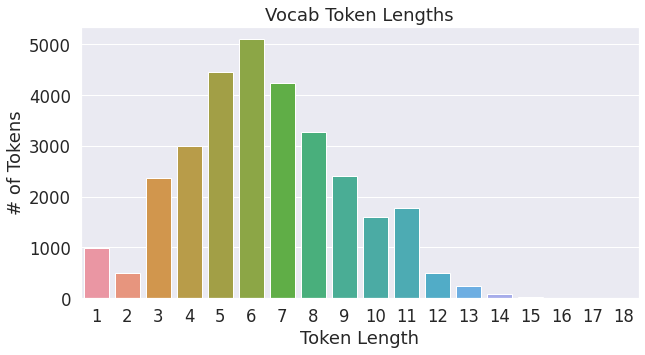

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Measure the length of every token in the vocab.
token_lengths = [len(token) for token in tokenizer.vocab.keys()]

# Plot the number of tokens of each length.
sns.countplot(token_lengths)
plt.title('Vocab Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('# of Tokens')

print('Maximum token length:', max(token_lengths))

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 10.2 MB/s 
     |████████████████████████████████| 182 kB 81.7 MB/s 
     |████████████████████████████████| 7.6 MB 62.1 MB/s 


In [ ]:
from transformers import AutoTokenizer,AutoModel, PreTrainedModel,PretrainedConfig
from typing import Dict
import torch

class ColBERTConfig(PretrainedConfig):
    model_type = "ColBERT"
    bert_model: str
    compression_dim: int = 768
    dropout: float = 0.0
    return_vecs: bool = False
    trainable: bool = True

class ColBERT(PreTrainedModel):
    """
    ColBERT model from: https://arxiv.org/pdf/2004.12832.pdf
    We use a dot-product instead of cosine per term (slightly better)
    """
    config_class = ColBERTConfig
    base_model_prefix = "bert_model"

    def __init__(self,
                 cfg) -> None:
        super().__init__(cfg)
        
        self.bert_model = AutoModel.from_pretrained(cfg.bert_model)

        for p in self.bert_model.parameters():
            p.requires_grad = cfg.trainable

        self.compressor = torch.nn.Linear(self.bert_model.config.hidden_size, cfg.compression_dim)

    def forward(self,
                query: Dict[str, torch.LongTensor],
                document: Dict[str, torch.LongTensor]):

        query_vecs = self.forward_representation(query)
        document_vecs = self.forward_representation(document)

        score = self.forward_aggregation(query_vecs,document_vecs,query["attention_mask"],document["attention_mask"])
        return score

    def forward_representation(self,
                               tokens,
                               sequence_type=None) -> torch.Tensor:
        
        vecs = self.bert_model(**tokens)[0] # assuming a distilbert model here
        vecs = self.compressor(vecs)

        # if encoding only, zero-out the mask values so we can compress storage
        if sequence_type == "doc_encode" or sequence_type == "query_encode": 
            vecs = vecs * tokens["tokens"]["mask"].unsqueeze(-1)

        return vecs

    def forward_aggregation(self,query_vecs, document_vecs,query_mask,document_mask):
        
        # create initial term-x-term scores (dot-product)
        score = torch.bmm(query_vecs, document_vecs.transpose(2,1))

        # mask out padding on the doc dimension (mask by -1000, because max should not select those, setting it to 0 might select them)
        exp_mask = document_mask.bool().unsqueeze(1).expand(-1,score.shape[1],-1)
        score[~exp_mask] = - 10000

        # max pooling over document dimension
        score = score.max(-1).values

        # mask out paddding query values
        score[~(query_mask.bool())] = 0

        # sum over query values
        score = score.sum(-1)

        return score

#
# init the model & tokenizer (using the distilbert tokenizer)
#
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") 
model = ColBERT.from_pretrained("sebastian-hofstaetter/colbert-distilbert-margin_mse-T2-msmarco")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/193 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# our relevant example
passage1_input = tokenizer("We are very happy to show you the 🤗 Transformers library for pre-trained language models. We are helping the community work together towards the goal of advancing NLP 🔥.",return_tensors="pt")
# a non-relevant example
passage2_input = tokenizer("Hmm I don't like this new movie about transformers that i got from my local library. Those transformers are robots?",return_tensors="pt")

# the user query -> which should give us a better score for the first passage
query_input = tokenizer("what is the transformers library")
# adding the mask augmentation, we used 8 as the fixed number for training regardless of batch-size
# it has a somewhat (although not huge) positive impact on effectiveness, we hypothesize that might be due to the increased
# capacity of the query encoding, not so much because of the [MASK] pre-training, but who knows :)
query_input.input_ids += [103] * 8 # [MASK]
query_input.attention_mask += [1] * 8
query_input["input_ids"] = torch.LongTensor(query_input.input_ids).unsqueeze(0)
query_input["attention_mask"] = torch.LongTensor(query_input.attention_mask).unsqueeze(0)

#print("Passage 1 Tokenized:",passage1_input)
#print("Passage 2 Tokenized:",passage2_input)
#print("Query Tokenized:",query_input)

# note how we call the bert model for pairs, can be changed to: forward_representation and forward_aggregation
score_for_p1 = model.forward(query_input,passage1_input).squeeze(0)
score_for_p2 = model.forward(query_input,passage2_input).squeeze(0)

print("---")
print("Score passage 1 <-> query: ",float(score_for_p1))
print("Score passage 2 <-> query: ",float(score_for_p2))

---
Score passage 1 <-> query:  106.46385192871094
Score passage 2 <-> query:  99.99707794189453
